In [99]:
# Import dependencies 
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from prophet import Prophet
import nltk
import matplotlib.pyplot as plt
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split


In [100]:
# Load the news_articles.csv into a DataFrame.
stock_data_df = pd.read_csv('Resources/stock_yfinance_data.csv')
tweet_data_df = pd.read_csv('Resources/stock_tweets.csv')


### Prepare Stock Data

In [101]:
# Display the stock data 
stock_names_of_interest = ['TSLA', 'MSFT', 'PG', 'META', 'AMZN']

# Filter DataFrame to only include specified stocks
filtered_stock_data_df = stock_data_df[stock_data_df['Stock Name'].isin(stock_names_of_interest)]

# Remove unnecessary columns
filtered_stock_data_df =filtered_stock_data_df.drop(columns=['High', 'Low', 'Adj Close', 'Volume'])

# Add a new column to calculate the price change
filtered_stock_data_df['Price Change'] =filtered_stock_data_df['Close'] - filtered_stock_data_df['Open']

# Remove the Open and Close columns
filtered_stock_data_df = filtered_stock_data_df[['Date', 'Stock Name', 'Price Change']]

filtered_stock_data_df


,Date,Stock Name,Price Change
0,2021-09-30,TSLA,-1.839996
1,2021-10-01,TSLA,-1.059998
2,2021-10-04,TSLA,-4.989990
3,2021-10-05,TSLA,-1.403351
4,2021-10-06,TSLA,2.183319
...,...,...,...
1255,2022-09-23,AMZN,-2.220001
1256,2022-09-26,AMZN,1.849998
1257,2022-09-27,AMZN,-2.789993
1258,2022-09-28,AMZN,3.630005


### Prepare Tweet Data

In [102]:
tweet_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80793 entries, 0 to 80792
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Date          80793 non-null  object
 1   Tweet         80793 non-null  object
 2   Stock Name    80793 non-null  object
 3   Company Name  80793 non-null  object
dtypes: object(4)
memory usage: 2.5+ MB


In [103]:
# Display the tweet data
tweet_data_df.head()

,Date,Tweet,Stock Name,Company Name
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc."
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc."
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc."
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc."
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc."


In [104]:
# Convert the 'Date' column to a datetime object
tweet_data_df['Date'] = pd.to_datetime(tweet_data_df['Date'])
tweet_data_df['Date'] = tweet_data_df['Date'].dt.date

# Filter the DataFrame to only include the specified stocks
tweets_of_interest = ['TSLA', 'MSFT', 'PG', 'META', 'AMZN']
filtered_tweet_data_df = tweet_data_df[tweet_data_df['Stock Name'].isin(tweets_of_interest)]
filtered_tweet_data_df = filtered_tweet_data_df[['Date', 'Stock Name', 'Tweet']]

filtered_tweet_data_df

,Date,Stock Name,Tweet
0,2022-09-29,TSLA,Mainstream media has done an amazing job at br...
1,2022-09-29,TSLA,Tesla delivery estimates are at around 364k fr...
2,2022-09-29,TSLA,3/ Even if I include 63.0M unvested RSUs as of...
3,2022-09-29,TSLA,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...
4,2022-09-29,TSLA,"@RealDanODowd @Tesla Stop trying to kill kids,..."
...,...,...,...
52435,2021-09-30,AMZN,My top 10 holdings make up 66% of my portfolio...
52436,2021-09-30,AMZN,Amazon $AMZN has 4X the market cap of Alibaba ...
52437,2021-09-30,AMZN,Returns over the last 10 Years:\n\nBitcoin $BT...
52438,2021-09-30,AMZN,Great snapshot of what it looks like when an i...


### Implement VADER Sentiment Analyzer on the Tweet data

In [105]:
# Initialize the SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
sentences = filtered_tweet_data_df["Tweet"]

# Function to analyze sentiment of each sentence
def analyze_sentiment(sentences):
    return analyzer.polarity_scores(sentences)

def vader_sentiment_label(vader_score):
    if vader_score >= 0.05:
        return 'Positive'
    elif vader_score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply the sentiment analysis to each tweet and create new columns
filtered_tweet_data_df[['Neg', 'Neu', 'Pos', 'Compound']] = filtered_tweet_data_df['Tweet'].apply(lambda x: pd.Series(analyze_sentiment(x)))
filtered_tweet_data_df['Sentiment'] = filtered_tweet_data_df['Compound'].apply(vader_sentiment_label)
filtered_tweet_data_df

,Date,Stock Name,Tweet,Neg,Neu,Pos,Compound,Sentiment
0,2022-09-29,TSLA,Mainstream media has done an amazing job at br...,0.127,0.758,0.115,0.0772,Positive
1,2022-09-29,TSLA,Tesla delivery estimates are at around 364k fr...,0.000,1.000,0.000,0.0000,Neutral
2,2022-09-29,TSLA,3/ Even if I include 63.0M unvested RSUs as of...,0.000,0.951,0.049,0.2960,Positive
3,2022-09-29,TSLA,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,0.273,0.590,0.137,-0.7568,Negative
4,2022-09-29,TSLA,"@RealDanODowd @Tesla Stop trying to kill kids,...",0.526,0.474,0.000,-0.8750,Negative
...,...,...,...,...,...,...,...,...
52435,2021-09-30,AMZN,My top 10 holdings make up 66% of my portfolio...,0.000,0.928,0.072,0.4515,Positive
52436,2021-09-30,AMZN,Amazon $AMZN has 4X the market cap of Alibaba ...,0.095,0.873,0.032,-0.5106,Negative
52437,2021-09-30,AMZN,Returns over the last 10 Years:\n\nBitcoin $BT...,0.089,0.821,0.091,-0.2263,Negative
52438,2021-09-30,AMZN,Great snapshot of what it looks like when an i...,0.000,0.740,0.260,0.9369,Positive


In [106]:
train_df, test_df = train_test_split(filtered_tweet_data_df, test_size=0.2, random_state=42)
sia = SentimentIntensityAnalyzer()

def analyze_sentiment(text):
    return sia.polarity_scores(text)['compound']

# Apply sentiment analysis on the train and test data
train_df['VADER_Score'] = train_df['Tweet'].apply(analyze_sentiment)
test_df['VADER_Score'] = test_df['Tweet'].apply(analyze_sentiment)

def vader_sentiment_label(vader_score):
    if vader_score >= 0.05:
        return 'Positive'
    elif vader_score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply the sentiment label function
test_df['VADER_Label'] = test_df['VADER_Score'].apply(vader_sentiment_label)

test_df


,Date,Stock Name,Tweet,Neg,Neu,Pos,Compound,Sentiment,VADER_Score,VADER_Label
19100,2022-03-10,TSLA,"This @Tesla #FSD makes a sudden right turn, al...",0.073,0.927,0.000,-0.4574,Negative,-0.4574,Negative
32329,2021-11-07,TSLA,You have to wonder why Elon would take to Twit...,0.000,0.918,0.082,0.5267,Positive,0.5267,Positive
31744,2021-11-10,TSLA,I'll be that Cathie Wood bought some $TSLA tod...,0.000,1.000,0.000,0.0000,Neutral,0.0000,Neutral
31244,2021-11-15,TSLA,Me looking forward to another week of Elon sel...,0.000,1.000,0.000,0.0000,Neutral,0.0000,Neutral
24115,2022-01-18,TSLA,$AMC now the second most bought stock on the d...,0.000,0.914,0.086,0.5826,Positive,0.5826,Positive
...,...,...,...,...,...,...,...,...,...,...
22822,2022-01-27,TSLA,"Toni Sacconaghi, long-time $TSLA bear but high...",0.141,0.732,0.127,0.0337,Neutral,0.0337,Neutral
50940,2022-02-05,AMZN,$AMZN (daily) Prior support is now resistance....,0.000,0.722,0.278,0.4019,Positive,0.4019,Positive
12465,2022-05-09,TSLA,This day 8 years ago I bought my first Tesla! ...,0.000,1.000,0.000,0.0000,Neutral,0.0000,Neutral
24959,2022-01-11,TSLA,10yr TYs moving up in front of Powell’s testim...,0.074,0.831,0.094,0.1376,Positive,0.1376,Positive


In [107]:
# Calculate accuracy
accuracy = accuracy_score(test_df['Sentiment'], test_df['VADER_Label'])
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 100.00%


In [108]:
# Group the DataFrame by 'Date' and 'Stock Name' and calculate the mean of the 'compound' column
mean_score_df = filtered_tweet_data_df.groupby(['Date', 'Stock Name'])['Compound'].mean().reset_index()
mean_score_df.rename(columns={'Compound': 'Mean Compound'}, inplace=True)

mean_score_df

,Date,Stock Name,Mean Compound
0,2021-09-30,AMZN,0.246480
1,2021-09-30,META,0.472467
2,2021-09-30,MSFT,0.246480
3,2021-09-30,PG,0.246480
4,2021-09-30,TSLA,0.231552
...,...,...,...
1763,2022-09-29,AMZN,0.117650
1764,2022-09-29,META,-0.051600
1765,2022-09-29,MSFT,0.117650
1766,2022-09-29,PG,0.117650


In [109]:
filtered_stock_data_df.loc[:, 'Date'] = pd.to_datetime(filtered_stock_data_df['Date'])
mean_score_df.loc[:, 'Date'] = pd.to_datetime(mean_score_df['Date'])

new_stock_data_df = filtered_stock_data_df[['Date', 'Stock Name', 'Price Change']]
new_tweet_data_df = mean_score_df[['Date', 'Stock Name', 'Mean Compound']]
merged_df = pd.merge(new_stock_data_df, new_tweet_data_df, on=['Date', 'Stock Name'], how='inner')

merged_df.head()


,Date,Stock Name,Price Change,Mean Compound
0,2021-09-30 00:00:00,TSLA,-1.839996,0.231552
1,2021-10-01 00:00:00,TSLA,-1.059998,0.233704
2,2021-10-04 00:00:00,TSLA,-4.989990,0.135388
3,2021-10-05 00:00:00,TSLA,-1.403351,0.069445
4,2021-10-06 00:00:00,TSLA,2.183319,0.199940


### Scaling the Data

In [110]:
from sklearn.preprocessing import StandardScaler

# Inpmlement the StandardScaler
scaler = StandardScaler()

# Select the columns to be scaled
merged_df[['Mean Compound', 'Price Change']] = scaler.fit_transform(merged_df[['Mean Compound', 'Price Change']])
merged_df.loc[:, 'Date'] = pd.to_datetime(merged_df['Date']).dt.date

# Stadardized DataFrame
print(merged_df.head())

         Date Stock Name  Price Change  Mean Compound
0  2021-09-30       TSLA     -0.269702       0.209584
1  2021-10-01       TSLA     -0.141924       0.222027
2  2021-10-04       TSLA     -0.785731      -0.346425
3  2021-10-05       TSLA     -0.198172      -0.727699
4  2021-10-06       TSLA      0.389392       0.026805


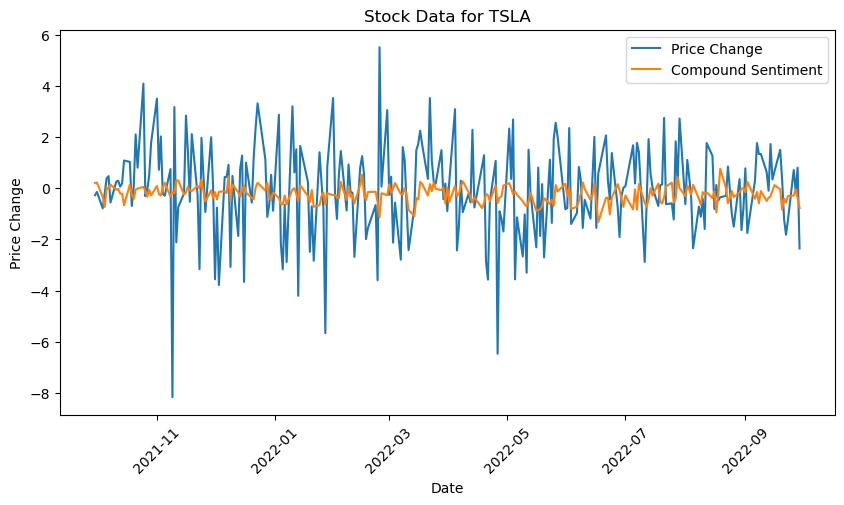

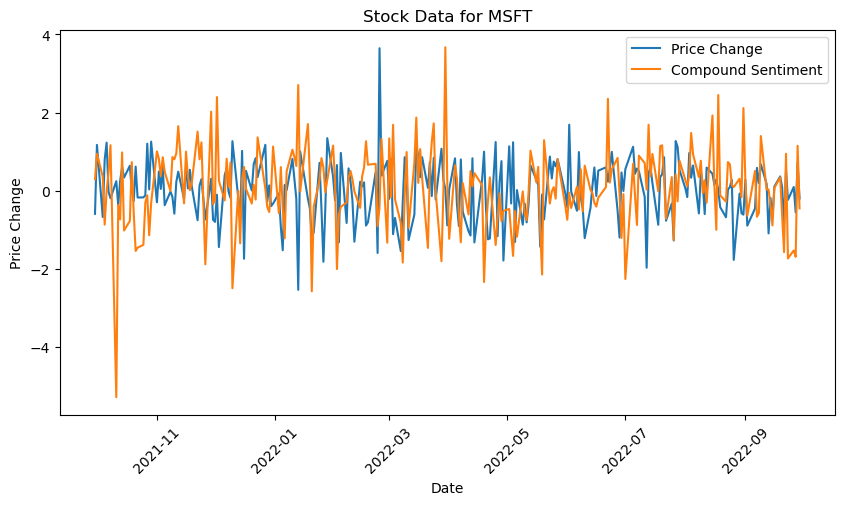

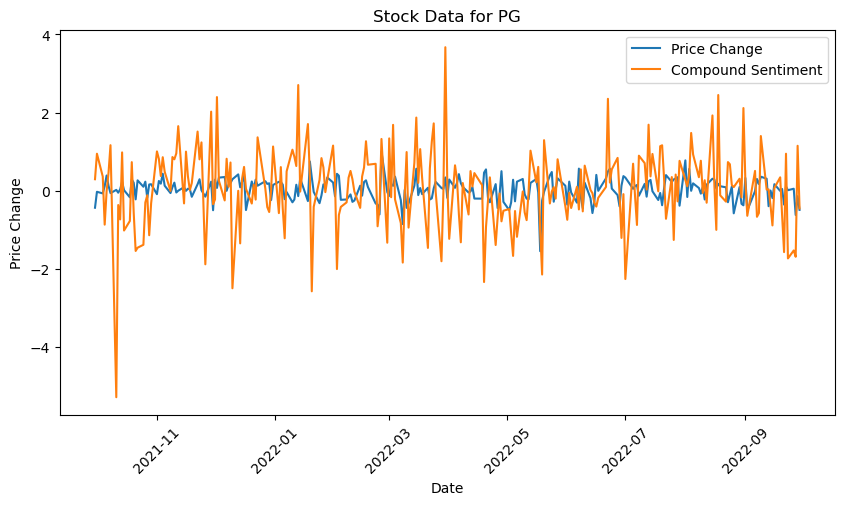

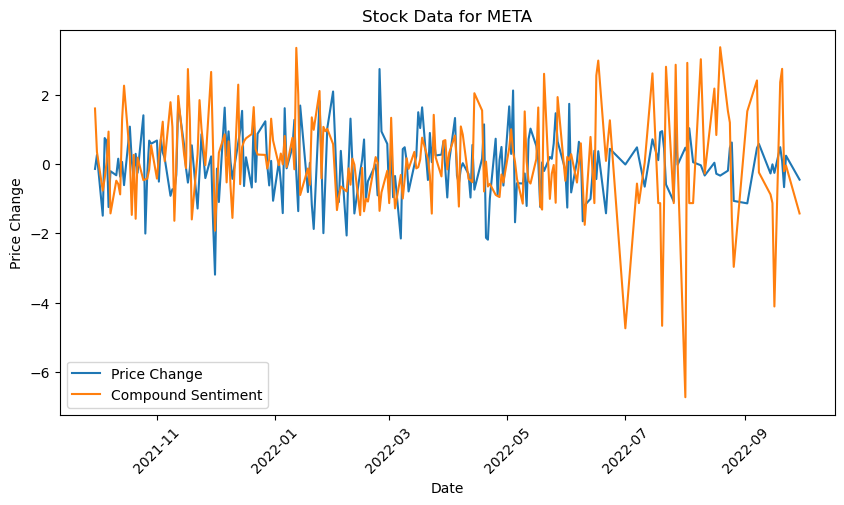

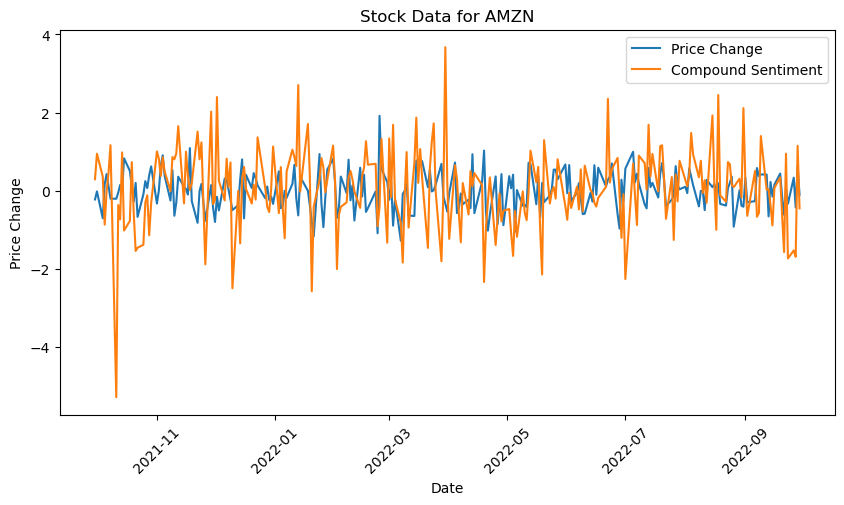

In [111]:
# Define the specific date range
# merged_df['Date'] = pd.to_datetime(merged_df['Date'])
# start_date = '2022-07-01'
# end_date = '2022-09-30'

# merged_df = merged_df[(merged_df['Date'] >= start_date) & (merged_df['Date'] <= end_date)]

for stock_name in stock_names_of_interest:
    # Filter the DataFrame for the current stock
    stock_df = merged_df[merged_df['Stock Name'] == stock_name]
    
    # Plot the stock data
    plt.figure(figsize=(10, 5))
    plt.plot(stock_df['Date'], stock_df[['Price Change', 'Mean Compound']], label=stock_name)
    plt.title(f'Stock Data for {stock_name}')
    plt.xlabel('Date')
    plt.xticks(rotation=45)
    plt.ylabel('Price Change')
    plt.legend(['Price Change', 'Compound Sentiment'])
    plt.show()

### Creating Stock Specific Dataframes

In [159]:
df_tsla = merged_df[merged_df['Stock Name'] == 'TSLA']
df_msft = merged_df[merged_df['Stock Name'] == 'MSFT']
df_pg = merged_df[merged_df['Stock Name'] == 'PG']
df_meta = merged_df[merged_df['Stock Name'] == 'META']
df_amzn = merged_df[merged_df['Stock Name'] == 'AMZN']

### Predict and Plot TSLA

In [113]:
# Prepare data for Prophet
tsla_sentiment_prophet_df = df_tsla.rename(columns={'Date': 'ds', 'Mean Compound': 'y'})

# Convert 'ds' to datetime
tsla_sentiment_prophet_df['ds'] = pd.to_datetime(tsla_sentiment_prophet_df['ds'])

# Check the DataFrame
tsla_sentiment_prophet_df

,ds,Stock Name,Price Change,y
0,2021-09-30,TSLA,-0.269702,0.209584
1,2021-10-01,TSLA,-0.141924,0.222027
2,2021-10-04,TSLA,-0.785731,-0.346425
3,2021-10-05,TSLA,-0.198172,-0.727699
4,2021-10-06,TSLA,0.389392,0.026805
...,...,...,...,...
247,2022-09-23,TSLA,-1.239512,-0.298939
248,2022-09-26,TSLA,0.716490,-0.287775
249,2022-09-27,TSLA,-0.115712,-0.041141
250,2022-09-28,TSLA,0.806588,-0.392712


In [114]:
model = Prophet()

# Fit the model on the historical sentiment data
model.fit(tsla_sentiment_prophet_df)

# Create a future dataframe for the next 30 days
future = model.make_future_dataframe(periods=30)

# Forecast future sentiment values
forecast_sentiment = model.predict(future)

# Display the forecasted sentiment values (yhat is the predicted value)
print(forecast_sentiment[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

06:40:30 - cmdstanpy - INFO - Chain [1] start processing
06:40:30 - cmdstanpy - INFO - Chain [1] done processing


            ds      yhat  yhat_lower  yhat_upper
0   2021-09-30 -0.130433   -0.536844    0.262086
1   2021-10-01 -0.049821   -0.436025    0.330888
2   2021-10-04 -0.136026   -0.556027    0.257240
3   2021-10-05 -0.172788   -0.587045    0.222786
4   2021-10-06 -0.176624   -0.554402    0.216371
..         ...       ...         ...         ...
277 2022-10-25 -0.388734   -0.774966    0.037284
278 2022-10-26 -0.392537   -0.760586    0.016631
279 2022-10-27 -0.350350   -0.721689    0.027968
280 2022-10-28 -0.269704   -0.691206    0.125674
281 2022-10-29 -0.153522   -0.560102    0.242169

[282 rows x 4 columns]


In [115]:
# Prepare forecasted sentiment data for future stock price prediction
forecasted_sentiment_df = forecast_sentiment[['ds', 'yhat']].rename(columns={'yhat': 'Sentiment'})

forecasted_sentiment_df

,ds,Sentiment
0,2021-09-30,-0.130433
1,2021-10-01,-0.049821
2,2021-10-04,-0.136026
3,2021-10-05,-0.172788
4,2021-10-06,-0.176624
...,...,...
277,2022-10-25,-0.388734
278,2022-10-26,-0.392537
279,2022-10-27,-0.350350
280,2022-10-28,-0.269704


In [116]:
# Prepare data for Prophet
df_tsla = df_tsla.rename(columns={'Date': 'ds', 'Price Change': 'y'})

# Convert 'ds' to datetime
df_tsla['ds'] = pd.to_datetime(df_tsla['ds'])


In [117]:
# Merge stock price data with sentiment forecast
merged_data = pd.merge(df_tsla, forecasted_sentiment_df, on='ds', how='left')

# Check the DataFrame
merged_data


,ds,Stock Name,y,Mean Compound,Sentiment
0,2021-09-30,TSLA,-0.269702,0.209584,-0.130433
1,2021-10-01,TSLA,-0.141924,0.222027,-0.049821
2,2021-10-04,TSLA,-0.785731,-0.346425,-0.136026
3,2021-10-05,TSLA,-0.198172,-0.727699,-0.172788
4,2021-10-06,TSLA,0.389392,0.026805,-0.176624
...,...,...,...,...,...
247,2022-09-23,TSLA,-1.239512,-0.298939,-0.250706
248,2022-09-26,TSLA,0.716490,-0.287775,-0.336808
249,2022-09-27,TSLA,-0.115712,-0.041141,-0.373536
250,2022-09-28,TSLA,0.806588,-0.392712,-0.377338


In [118]:
# Initialize the Prophet model
model = Prophet()

# Add the sentiment as an additional regressor
model.add_regressor('Sentiment')

# Fit the model with stock price and sentiment data
model.fit(merged_data)

06:40:30 - cmdstanpy - INFO - Chain [1] start processing
06:40:31 - cmdstanpy - INFO - Chain [1] done processing


In [119]:
# Create a dataframe for future stock price predictions
future = model.make_future_dataframe(periods=30)

# Merge with forecasted sentiment for future dates
future = pd.merge(future, forecasted_sentiment_df, on='ds', how='left')

# Forecast future stock prices
forecast = model.predict(future)

# Display the forecasted stock price changes
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])



            ds      yhat  yhat_lower  yhat_upper
0   2021-09-30 -0.264068   -2.491151    2.132011
1   2021-10-01 -0.178693   -2.432753    2.295970
2   2021-10-04  0.521470   -1.730933    2.869797
3   2021-10-05 -0.132667   -2.597977    2.088279
4   2021-10-06  0.254564   -1.920118    2.406781
..         ...       ...         ...         ...
277 2022-10-25 -0.318191   -2.419385    2.077301
278 2022-10-26  0.068828   -2.179259    2.407651
279 2022-10-27 -0.452692   -2.609041    1.816349
280 2022-10-28 -0.367529   -2.638599    1.821243
281 2022-10-29 -1.943230   -4.427227    0.281407

[282 rows x 4 columns]


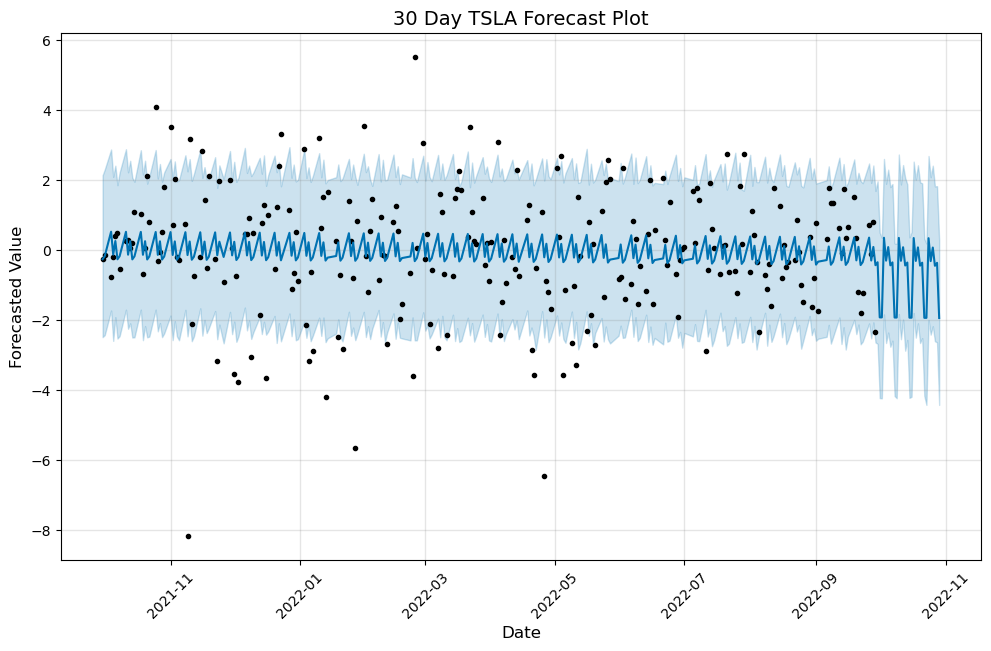

In [123]:
import matplotlib.dates as mdates

fig = model.plot(forecast)

# Customizing title and labels
plt.title("30 Day TSLA Forecast Plot", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.ylabel("Forecasted Value", fontsize=12)
plt.yticks(fontsize=10)

# Set daily x-axis ticks
# ax = fig.gca()  # Get the current axes instance
# x.xaxis.set_major_locator(mdates.DayLocator(interval=3))  # Set daily interval for x-axis
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format as 'YYYY-MM-DD'

plt.show()

### Predict and Plot MSFT

In [124]:
# Prepare data for Prophet
msft_sentiment_prophet_df = df_msft.rename(columns={'Date': 'ds', 'Mean Compound': 'y'})

# Convert 'ds' to datetime
msft_sentiment_prophet_df['ds'] = pd.to_datetime(msft_sentiment_prophet_df['ds'])

# Check the DataFrame
msft_sentiment_prophet_df

,ds,Stock Name,Price Change,y
252,2021-09-30,MSFT,-0.589146,0.295895
253,2021-10-01,MSFT,1.175181,0.948424
254,2021-10-04,MSFT,-0.671060,0.366261
255,2021-10-05,MSFT,0.803314,-0.866148
256,2021-10-06,MSFT,1.232513,-0.005804
...,...,...,...,...
499,2022-09-23,MSFT,-0.233662,-1.730685
500,2022-09-26,MSFT,0.097250,-1.526523
501,2022-09-27,MSFT,-0.553108,-1.688333
502,2022-09-28,MSFT,0.729593,1.151846


In [125]:
model = Prophet()

# Fit the model on the historical sentiment data
model.fit(msft_sentiment_prophet_df)

# Create a future dataframe for the next 30 days
future = model.make_future_dataframe(periods=30)

# Forecast future sentiment values
forecast_sentiment = model.predict(future)

# Display the forecasted sentiment values (yhat is the predicted value)
print(forecast_sentiment[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

06:57:27 - cmdstanpy - INFO - Chain [1] start processing
06:57:27 - cmdstanpy - INFO - Chain [1] done processing


            ds      yhat  yhat_lower  yhat_upper
0   2021-09-30  0.243899   -0.923307    1.496104
1   2021-10-01  0.085356   -1.291240    1.296294
2   2021-10-04 -0.040415   -1.328439    1.297845
3   2021-10-05  0.178970   -1.015610    1.490872
4   2021-10-06  0.164406   -1.069742    1.420673
..         ...       ...         ...         ...
277 2022-10-25  0.023161   -1.228765    1.234690
278 2022-10-26  0.008660   -1.272846    1.305983
279 2022-10-27  0.084946   -1.269986    1.398375
280 2022-10-28 -0.073533   -1.408309    1.145798
281 2022-10-29  0.066078   -1.231396    1.358194

[282 rows x 4 columns]


In [126]:
# Prepare forecasted sentiment data for future stock price prediction
forecasted_sentiment_df = forecast_sentiment[['ds', 'yhat']].rename(columns={'yhat': 'Sentiment'})

forecasted_sentiment_df

,ds,Sentiment
0,2021-09-30,0.243899
1,2021-10-01,0.085356
2,2021-10-04,-0.040415
3,2021-10-05,0.178970
4,2021-10-06,0.164406
...,...,...
277,2022-10-25,0.023161
278,2022-10-26,0.008660
279,2022-10-27,0.084946
280,2022-10-28,-0.073533


In [127]:
# Prepare data for Prophet
df_msft = df_msft.rename(columns={'Date': 'ds', 'Price Change': 'y'})

# Convert 'ds' to datetime
df_msft['ds'] = pd.to_datetime(df_msft['ds'])


In [128]:
# Merge stock price data with sentiment forecast
merged_data = pd.merge(df_msft, forecasted_sentiment_df, on='ds', how='left')

# Check the DataFrame
merged_data


,ds,Stock Name,y,Mean Compound,Sentiment
0,2021-09-30,MSFT,-0.589146,0.295895,0.243899
1,2021-10-01,MSFT,1.175181,0.948424,0.085356
2,2021-10-04,MSFT,-0.671060,0.366261,-0.040415
3,2021-10-05,MSFT,0.803314,-0.866148,0.178970
4,2021-10-06,MSFT,1.232513,-0.005804,0.164406
...,...,...,...,...,...
247,2022-09-23,MSFT,-0.233662,-1.730685,-0.059411
248,2022-09-26,MSFT,0.097250,-1.526523,-0.184989
249,2022-09-27,MSFT,-0.553108,-1.688333,0.034459
250,2022-09-28,MSFT,0.729593,1.151846,0.019958


In [129]:
# Initialize the Prophet model
model = Prophet()

# Add the sentiment as an additional regressor
model.add_regressor('Sentiment')

# Fit the model with stock price and sentiment data
model.fit(merged_data)

06:57:38 - cmdstanpy - INFO - Chain [1] start processing
06:57:38 - cmdstanpy - INFO - Chain [1] done processing


In [130]:
# Create a dataframe for future stock price predictions
future = model.make_future_dataframe(periods=30)

# Merge with forecasted sentiment for future dates
future = pd.merge(future, forecasted_sentiment_df, on='ds', how='left')

# Forecast future stock prices
forecast = model.predict(future)

# Display the forecasted stock price changes
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])



            ds      yhat  yhat_lower  yhat_upper
0   2021-09-30  0.017146   -0.932990    1.022479
1   2021-10-01 -0.012706   -0.973938    0.969211
2   2021-10-04  0.042407   -1.020415    0.957532
3   2021-10-05 -0.037592   -0.980606    0.956181
4   2021-10-06  0.123865   -0.908465    1.080152
..         ...       ...         ...         ...
277 2022-10-25 -0.070401   -1.052372    0.954344
278 2022-10-26  0.091154   -0.867403    1.174668
279 2022-10-27 -0.016736   -0.932358    0.972305
280 2022-10-28 -0.046490   -1.041792    0.952769
281 2022-10-29 -0.099293   -1.029246    0.912897

[282 rows x 4 columns]


c:\Users\mdmoo\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\mdmoo\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


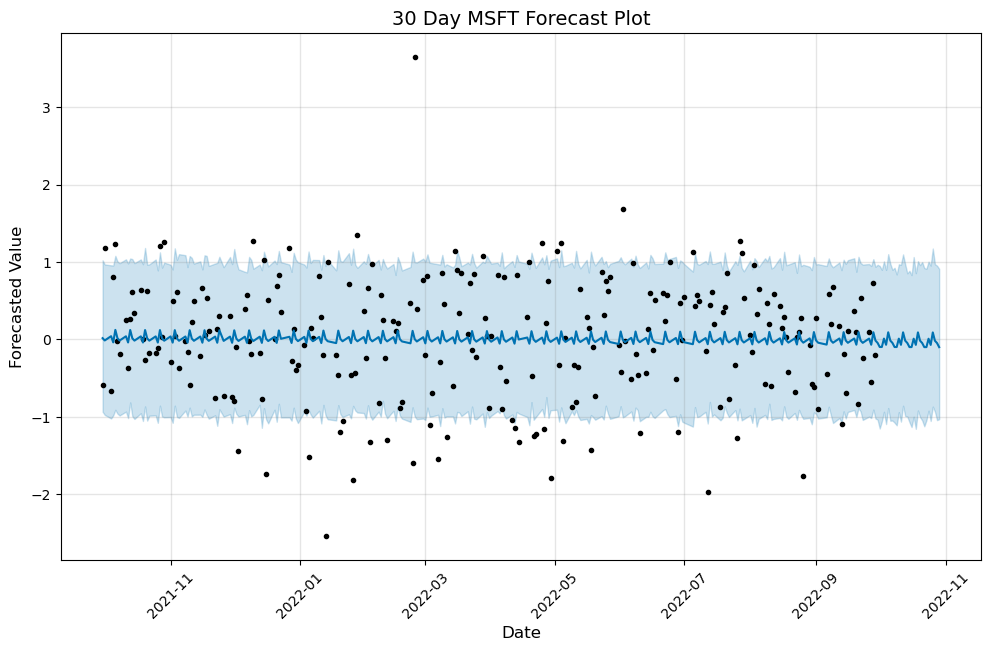

In [131]:
import matplotlib.dates as mdates

fig = model.plot(forecast)

# Customizing title and labels
plt.title("30 Day MSFT Forecast Plot", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.ylabel("Forecasted Value", fontsize=12)
plt.yticks(fontsize=10)

# Set daily x-axis ticks
# ax = fig.gca()  # Get the current axes instance
# x.xaxis.set_major_locator(mdates.DayLocator(interval=3))  # Set daily interval for x-axis
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format as 'YYYY-MM-DD'

plt.show()

### Predict and Plot PG

In [134]:
# Prepare data for Prophet
pg_sentiment_prophet_df = df_pg.rename(columns={'Date': 'ds', 'Mean Compound': 'y'})

# Convert 'ds' to datetime
pg_sentiment_prophet_df['ds'] = pd.to_datetime(pg_sentiment_prophet_df['ds'])

# Check the DataFrame
pg_sentiment_prophet_df

,ds,Stock Name,Price Change,y
504,2021-09-30,PG,-0.433521,0.295895
505,2021-10-01,PG,-0.025611,0.948424
506,2021-10-04,PG,-0.066569,0.366261
507,2021-10-05,PG,0.118547,-0.866148
508,2021-10-06,PG,0.392125,-0.005804
...,...,...,...,...
751,2022-09-23,PG,0.015343,-1.730685
752,2022-09-26,PG,0.053021,-1.526523
753,2022-09-27,PG,-0.620277,-1.688333
754,2022-09-28,PG,-0.138649,1.151846


In [135]:
model = Prophet()

# Fit the model on the historical sentiment data
model.fit(pg_sentiment_prophet_df)

# Create a future dataframe for the next 30 days
future = model.make_future_dataframe(periods=30)

# Forecast future sentiment values
forecast_sentiment = model.predict(future)

# Display the forecasted sentiment values (yhat is the predicted value)
print(forecast_sentiment[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

07:01:33 - cmdstanpy - INFO - Chain [1] start processing
07:01:33 - cmdstanpy - INFO - Chain [1] done processing


            ds      yhat  yhat_lower  yhat_upper
0   2021-09-30  0.243899   -1.031229    1.533270
1   2021-10-01  0.085356   -1.161922    1.345458
2   2021-10-04 -0.040415   -1.293721    1.242055
3   2021-10-05  0.178970   -1.114121    1.427088
4   2021-10-06  0.164406   -1.188874    1.465547
..         ...       ...         ...         ...
277 2022-10-25  0.023161   -1.264876    1.352657
278 2022-10-26  0.008660   -1.238451    1.244074
279 2022-10-27  0.084946   -1.240069    1.405011
280 2022-10-28 -0.073533   -1.303571    1.280292
281 2022-10-29  0.066078   -1.176124    1.378395

[282 rows x 4 columns]


In [136]:
# Prepare forecasted sentiment data for future stock price prediction
forecasted_sentiment_df = forecast_sentiment[['ds', 'yhat']].rename(columns={'yhat': 'Sentiment'})

forecasted_sentiment_df

,ds,Sentiment
0,2021-09-30,0.243899
1,2021-10-01,0.085356
2,2021-10-04,-0.040415
3,2021-10-05,0.178970
4,2021-10-06,0.164406
...,...,...
277,2022-10-25,0.023161
278,2022-10-26,0.008660
279,2022-10-27,0.084946
280,2022-10-28,-0.073533


In [137]:
# Prepare data for Prophet
df_pg = df_pg.rename(columns={'Date': 'ds', 'Price Change': 'y'})

# Convert 'ds' to datetime
df_pg['ds'] = pd.to_datetime(df_pg['ds'])


In [138]:
# Merge stock price data with sentiment forecast
merged_data = pd.merge(df_pg, forecasted_sentiment_df, on='ds', how='left')

# Check the DataFrame
merged_data


,ds,Stock Name,y,Mean Compound,Sentiment
0,2021-09-30,PG,-0.433521,0.295895,0.243899
1,2021-10-01,PG,-0.025611,0.948424,0.085356
2,2021-10-04,PG,-0.066569,0.366261,-0.040415
3,2021-10-05,PG,0.118547,-0.866148,0.178970
4,2021-10-06,PG,0.392125,-0.005804,0.164406
...,...,...,...,...,...
247,2022-09-23,PG,0.015343,-1.730685,-0.059411
248,2022-09-26,PG,0.053021,-1.526523,-0.184989
249,2022-09-27,PG,-0.620277,-1.688333,0.034459
250,2022-09-28,PG,-0.138649,1.151846,0.019958


In [139]:
# Initialize the Prophet model
model = Prophet()

# Add the sentiment as an additional regressor
model.add_regressor('Sentiment')

# Fit the model with stock price and sentiment data
model.fit(merged_data)

07:01:49 - cmdstanpy - INFO - Chain [1] start processing
07:01:50 - cmdstanpy - INFO - Chain [1] done processing


In [140]:
# Create a dataframe for future stock price predictions
future = model.make_future_dataframe(periods=30)

# Merge with forecasted sentiment for future dates
future = pd.merge(future, forecasted_sentiment_df, on='ds', how='left')

# Forecast future stock prices
forecast = model.predict(future)

# Display the forecasted stock price changes
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])



            ds      yhat  yhat_lower  yhat_upper
0   2021-09-30  0.078520   -0.287288    0.443875
1   2021-10-01  0.095421   -0.240882    0.476690
2   2021-10-04  0.103463   -0.289215    0.464219
3   2021-10-05  0.004645   -0.395964    0.372806
4   2021-10-06  0.099676   -0.282985    0.442993
..         ...       ...         ...         ...
277 2022-10-25 -0.080033   -0.456442    0.307048
278 2022-10-26  0.015037   -0.371025    0.395593
279 2022-10-27 -0.007891   -0.371252    0.371195
280 2022-10-28  0.009050   -0.348724    0.414533
281 2022-10-29 -0.221536   -0.582138    0.156783

[282 rows x 4 columns]


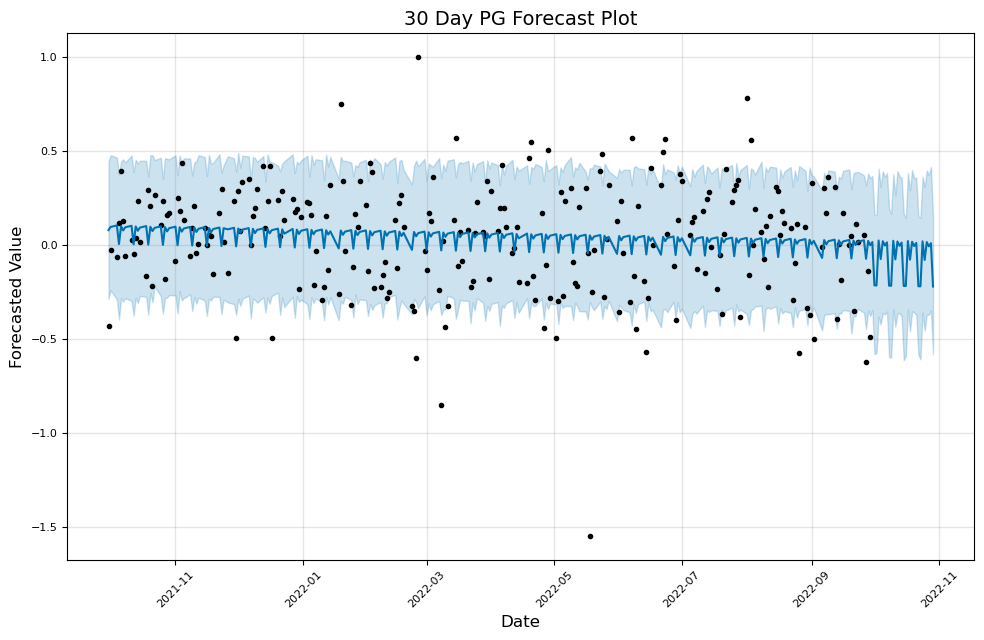

In [142]:
import matplotlib.dates as mdates

fig = model.plot(forecast)

# Customizing title and labels
plt.title("30 Day PG Forecast Plot", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.xticks(rotation=45, fontsize=8)
plt.ylabel("Forecasted Value", fontsize=12)
plt.yticks(fontsize=8)

# Set daily x-axis ticks
# ax = fig.gca()  # Get the current axes instance
# x.xaxis.set_major_locator(mdates.DayLocator(interval=3))  # Set daily interval for x-axis
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format as 'YYYY-MM-DD'

plt.show()

### Predict and Plot META

In [161]:
# Prepare data for Prophet
meta_sentiment_prophet_df = df_meta.rename(columns={'Date': 'ds', 'Mean Compound': 'y'})

# Convert 'ds' to datetime
meta_sentiment_prophet_df['ds'] = pd.to_datetime(meta_sentiment_prophet_df['ds'])

# Check the DataFrame
meta_sentiment_prophet_df

,ds,Stock Name,Price Change,y
756,2021-09-30,META,-0.141924,1.602525
757,2021-10-01,META,0.261074,0.346997
758,2021-10-04,META,-1.491789,-0.767748
759,2021-10-05,META,0.749251,-0.416952
760,2021-10-06,META,0.670621,0.053653
...,...,...,...,...
970,2022-09-19,META,0.487140,2.361301
971,2022-09-20,META,0.082507,2.746953
972,2022-09-21,META,-0.667783,-0.208170
973,2022-09-22,META,0.239774,-0.042615


In [162]:
model = Prophet()

# Fit the model on the historical sentiment data
model.fit(meta_sentiment_prophet_df)

# Create a future dataframe for the next 30 days
future = model.make_future_dataframe(periods=30)

# Forecast future sentiment values
forecast_sentiment = model.predict(future)

# Display the forecasted sentiment values (yhat is the predicted value)
print(forecast_sentiment[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

07:07:46 - cmdstanpy - INFO - Chain [1] start processing
07:07:46 - cmdstanpy - INFO - Chain [1] done processing


            ds      yhat  yhat_lower  yhat_upper
0   2021-09-30  0.330837   -1.388678    2.029862
1   2021-10-01  0.255125   -1.389970    2.012173
2   2021-10-04  0.248949   -1.457335    1.896588
3   2021-10-05  0.420085   -1.248433    2.129619
4   2021-10-06  0.184290   -1.642359    1.866480
..         ...       ...         ...         ...
244 2022-10-25 -0.078249   -1.787674    1.585595
245 2022-10-26 -0.314044   -2.150071    1.377604
246 2022-10-27 -0.176559   -1.780182    1.502566
247 2022-10-28 -0.252270   -1.925586    1.468063
248 2022-10-29  0.545772   -1.157020    2.232856

[249 rows x 4 columns]


In [163]:
# Prepare forecasted sentiment data for future stock price prediction
forecasted_sentiment_df = forecast_sentiment[['ds', 'yhat']].rename(columns={'yhat': 'Sentiment'})

forecasted_sentiment_df

,ds,Sentiment
0,2021-09-30,0.330837
1,2021-10-01,0.255125
2,2021-10-04,0.248949
3,2021-10-05,0.420085
4,2021-10-06,0.184290
...,...,...
244,2022-10-25,-0.078249
245,2022-10-26,-0.314044
246,2022-10-27,-0.176559
247,2022-10-28,-0.252270


In [164]:
# Prepare data for Prophet
df_meta = df_meta.rename(columns={'Date': 'ds', 'Price Change': 'y'})

# Convert 'ds' to datetime
df_meta['ds'] = pd.to_datetime(df_meta['ds'])


In [165]:
# Merge stock price data with sentiment forecast
merged_data = pd.merge(df_meta, forecasted_sentiment_df, on='ds', how='left')

# Check the DataFrame
merged_data


,ds,Stock Name,y,Mean Compound,Sentiment
0,2021-09-30,META,-0.141924,1.602525,0.330837
1,2021-10-01,META,0.261074,0.346997,0.255125
2,2021-10-04,META,-1.491789,-0.767748,0.248949
3,2021-10-05,META,0.749251,-0.416952,0.420085
4,2021-10-06,META,0.670621,0.053653,0.184290
...,...,...,...,...,...
214,2022-09-19,META,0.487140,2.361301,-0.204083
215,2022-09-20,META,0.082507,2.746953,-0.032946
216,2022-09-21,META,-0.667783,-0.208170,-0.268741
217,2022-09-22,META,0.239774,-0.042615,-0.131255


In [166]:
# Initialize the Prophet model
model = Prophet()

# Add the sentiment as an additional regressor
model.add_regressor('Sentiment')

# Fit the model with stock price and sentiment data
model.fit(merged_data)

07:07:47 - cmdstanpy - INFO - Chain [1] start processing
07:07:47 - cmdstanpy - INFO - Chain [1] done processing


In [167]:
# Create a dataframe for future stock price predictions
future = model.make_future_dataframe(periods=30)

# Merge with forecasted sentiment for future dates
future = pd.merge(future, forecasted_sentiment_df, on='ds', how='left')

# Forecast future stock prices
forecast = model.predict(future)

# Display the forecasted stock price changes
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])



            ds      yhat  yhat_lower  yhat_upper
0   2021-09-30 -0.051687   -1.224062    1.183536
1   2021-10-01 -0.110870   -1.298690    1.085099
2   2021-10-04  0.151043   -1.004213    1.331397
3   2021-10-05 -0.070577   -1.304607    1.102055
4   2021-10-06 -0.053821   -1.260649    1.024594
..         ...       ...         ...         ...
244 2022-10-25 -0.033798   -1.173339    1.161324
245 2022-10-26 -0.017042   -1.203583    1.129015
246 2022-10-27 -0.014239   -1.180561    1.139708
247 2022-10-28 -0.073422   -1.239831    1.111878
248 2022-10-29 -0.496769   -1.699904    0.637537

[249 rows x 4 columns]


### Predict and Plot AMZN

In [171]:
# Prepare data for Prophet
amzn_sentiment_prophet_df = df_amzn.rename(columns={'Date': 'ds', 'Mean Compound': 'y'})

# Convert 'ds' to datetime
amzn_sentiment_prophet_df['ds'] = pd.to_datetime(amzn_sentiment_prophet_df['ds'])

# Check the DataFrame
amzn_sentiment_prophet_df

,ds,Stock Name,Price Change,y
975,2021-09-30,AMZN,-0.221868,0.295895
976,2021-10-01,AMZN,-0.015375,0.948424
977,2021-10-04,AMZN,-0.702266,0.366261
978,2021-10-05,AMZN,0.166874,-0.866148
979,2021-10-06,AMZN,0.428820,-0.005804
...,...,...,...,...
1222,2022-09-23,AMZN,-0.331954,-1.730685
1223,2022-09-26,AMZN,0.334788,-1.526523
1224,2022-09-27,AMZN,-0.425330,-1.688333
1225,2022-09-28,AMZN,0.626387,1.151846


In [172]:
model = Prophet()

# Fit the model on the historical sentiment data
model.fit(amzn_sentiment_prophet_df)

# Create a future dataframe for the next 30 days
future = model.make_future_dataframe(periods=30)

# Forecast future sentiment values
forecast_sentiment = model.predict(future)

# Display the forecasted sentiment values (yhat is the predicted value)
print(forecast_sentiment[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

07:13:44 - cmdstanpy - INFO - Chain [1] start processing
07:13:44 - cmdstanpy - INFO - Chain [1] done processing


            ds      yhat  yhat_lower  yhat_upper
0   2021-09-30  0.243899   -1.041872    1.422539
1   2021-10-01  0.085356   -1.179948    1.374057
2   2021-10-04 -0.040415   -1.339679    1.231825
3   2021-10-05  0.178970   -1.180235    1.460271
4   2021-10-06  0.164406   -1.166054    1.392417
..         ...       ...         ...         ...
277 2022-10-25  0.023161   -1.212814    1.355232
278 2022-10-26  0.008660   -1.238354    1.339004
279 2022-10-27  0.084946   -1.161161    1.400159
280 2022-10-28 -0.073533   -1.333051    1.315330
281 2022-10-29  0.066078   -1.111983    1.417200

[282 rows x 4 columns]


In [173]:
# Prepare forecasted sentiment data for future stock price prediction
forecasted_sentiment_df = forecast_sentiment[['ds', 'yhat']].rename(columns={'yhat': 'Sentiment'})

forecasted_sentiment_df

,ds,Sentiment
0,2021-09-30,0.243899
1,2021-10-01,0.085356
2,2021-10-04,-0.040415
3,2021-10-05,0.178970
4,2021-10-06,0.164406
...,...,...
277,2022-10-25,0.023161
278,2022-10-26,0.008660
279,2022-10-27,0.084946
280,2022-10-28,-0.073533


In [174]:
# Prepare data for Prophet
df_amzn = df_amzn.rename(columns={'Date': 'ds', 'Price Change': 'y'})

# Convert 'ds' to datetime
df_amzn['ds'] = pd.to_datetime(df_amzn['ds'])


In [175]:
# Merge stock price data with sentiment forecast
merged_data = pd.merge(df_amzn, forecasted_sentiment_df, on='ds', how='left')

# Check the DataFrame
merged_data


,ds,Stock Name,y,Mean Compound,Sentiment
0,2021-09-30,AMZN,-0.221868,0.295895,0.243899
1,2021-10-01,AMZN,-0.015375,0.948424,0.085356
2,2021-10-04,AMZN,-0.702266,0.366261,-0.040415
3,2021-10-05,AMZN,0.166874,-0.866148,0.178970
4,2021-10-06,AMZN,0.428820,-0.005804,0.164406
...,...,...,...,...,...
247,2022-09-23,AMZN,-0.331954,-1.730685,-0.059411
248,2022-09-26,AMZN,0.334788,-1.526523,-0.184989
249,2022-09-27,AMZN,-0.425330,-1.688333,0.034459
250,2022-09-28,AMZN,0.626387,1.151846,0.019958


In [176]:
# Initialize the Prophet model
model = Prophet()

# Add the sentiment as an additional regressor
model.add_regressor('Sentiment')

# Fit the model with stock price and sentiment data
model.fit(merged_data)

07:13:44 - cmdstanpy - INFO - Chain [1] start processing
07:13:44 - cmdstanpy - INFO - Chain [1] done processing


In [177]:
# Create a dataframe for future stock price predictions
future = model.make_future_dataframe(periods=30)

# Merge with forecasted sentiment for future dates
future = pd.merge(future, forecasted_sentiment_df, on='ds', how='left')

# Forecast future stock prices
forecast = model.predict(future)

# Display the forecasted stock price changes
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])



            ds      yhat  yhat_lower  yhat_upper
0   2021-09-30 -0.020891   -0.620511    0.609160
1   2021-10-01 -0.098413   -0.709841    0.487031
2   2021-10-04 -0.054446   -0.706244    0.552233
3   2021-10-05 -0.016707   -0.629609    0.575403
4   2021-10-06 -0.018534   -0.618660    0.631500
..         ...       ...         ...         ...
277 2022-10-25  0.087210   -0.541644    0.650702
278 2022-10-26  0.085404   -0.509934    0.715318
279 2022-10-27  0.084814   -0.484019    0.709554
280 2022-10-28  0.007313   -0.658297    0.636403
281 2022-10-29  0.005007   -0.668444    0.613514

[282 rows x 4 columns]


c:\Users\mdmoo\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\mdmoo\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


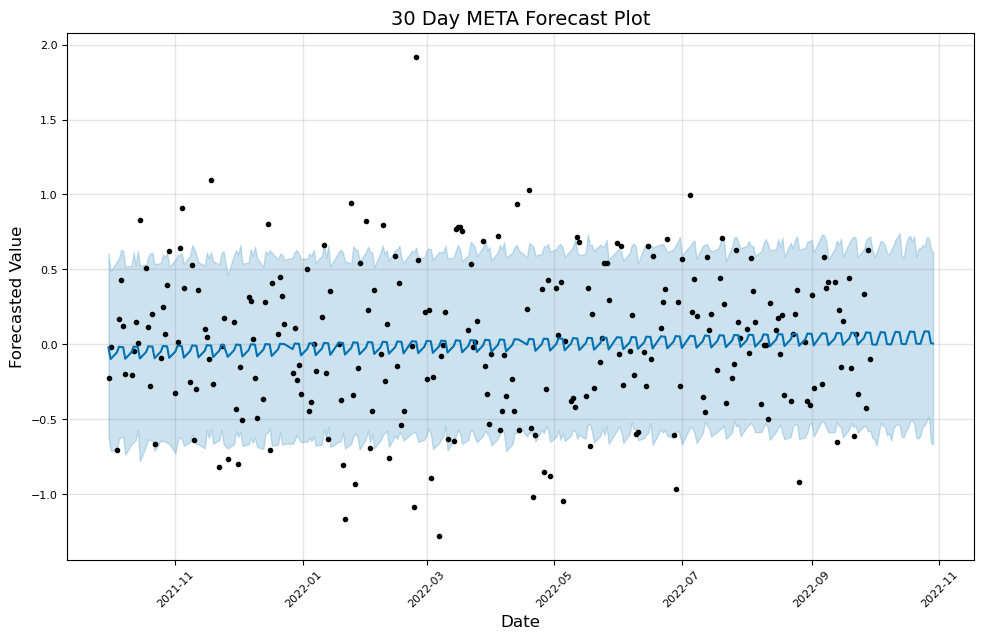

In [178]:
import matplotlib.dates as mdates

fig = model.plot(forecast)

# Customizing title and labels
plt.title("30 Day AMZN Forecast Plot", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.xticks(rotation=45, fontsize=8)
plt.ylabel("Forecasted Value", fontsize=12)
plt.yticks(fontsize=8)

plt.show()